# Cassava Disease Classification Using Transfer Learning with ResNet50

## Angel Sarmiento
https://www.kaggle.com/c/cassava-disease/data





### Introduction

This programming assignment correspond to a real Kaggle context: iCassava 2019 Fine-Grained Visual Categorization Challenge.  


### Problem Description

As the 2nd largest provider of carbohydrates in Africa, cassava is a key food security crop grown by small-holder farmers because it can withstand harsh conditions. At least 80% of small-holder farmer households in Sub-Saharan Africa grow cassava and viral diseases are major sources of poor yields. In this assignment, we introduce a dataset of 5 fine-grained cassava leaf disease categories with 9,436 labeled images collected during a regular survey in Uganda, mostly crowdsourced from farmers taking images of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab in Makarere University, Kampala. The dataset consists of leaf images of the cassava plant, with 9,436 annotated images and 12,595 unlabeled images of cassava leaves.

### Goals

The goal is to learn a model to classify a given image into these 4 disease categories or a 5th category indicating a healthy leaf, using the images in the training data. 


In [5]:

# This was originally a program I implemented in Google Colab, but my machine has a faster GPU than what is offered on Google Colab so I decided to implement it locally
#from google.colab import drive
#drive.mount('/content/drive')

In [15]:
# Importing Libraries

import torch
import torchvision
from torchsummary import summary
from os import listdir

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
%matplotlib inline

# This is absolutely necessary to pull models from torchvision
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
# setting the directory for the data
## NOTE: all data was imported using the kaggle API with the following command
# kaggle competitions download -c cassava-disease

data_directory = 'cassava-disease/train'

listdir()

['cassava-disease',
 'cassava-disease.zip',
 'cassava_classification 2.ipynb',
 'cassava_classification_colab.ipynb',
 'Programming_Assignment_CASAVA_CNNs1.pdf']

## Data Augmentation

This set of calls will set the device for calculations as 'GPU', transform the data out-of-place for augmentation, and normalize the data. Torch allows me to do it this way so as not to have to save more data in RAM.

In [17]:
# setting some parameters
n_epochs = 50

# seed for reproducability
random_seed = 1
torch.manual_seed(random_seed)

# setting up GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
# getting a set of augmentations to apply to the images
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(500),
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# getting the training data and setting up a train loader
train_data = datasets.ImageFolder(data_directory,transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# transforming the testing data as well 
test_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(500),
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        # this is the normalization component, one for each channel
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Doing the same with the test data
test_data = datasets.ImageFolder(data_directory,transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [19]:
# this is for later and also to make sure that pytorch is importing the proper class names (based on the folder names)
class_names = trainloader.dataset.classes
class_names

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

## Pre-Trained Model for Transfer Learning

The model chosen here will be ResNet50. A model pretrained using ImageNet data. This CNN has about 50 layers, but is not the only way I will train this model. 
I have decided to add two extra fully connected layers to the end, the first one with **ReLU** activation and the final one as a LogSoftmax layer. The optimizer chosen is **Adam** and the loss function chosen here is Negative Log Likelihood. The main reason for this decision is that I would need to add another layer in order to use Softmax and Cross Entropy cost instead.  

In [20]:
#importing a pretrained model
model = models.resnet50(pretrained = True)

In [21]:
# this is to 'freeze' the ResNet part of my model, since its already been trained
for param in model.parameters():
    param.requires_grad = False


# this changes the final set of layers defined in 'fc' above
# essentially, 1 Fully connected layer with ReLU activation and dropout
# then another fully connected layer with output = 5 for the 5 classes using LogSoftmax activation
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))

# setting the loss function                                 
criterion = nn.NLLLoss()
# setting the optimizer as Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.002)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# creating a bunch of lists so that I can append the values and use them for plotting 
epoch_num, train_accuracy, test_accuracy, train_loss_list, val_loss_list = [], [], [], [], []

## Training loop

This is just the typical training loop. This takes a **long** time, even with gpu training on Google Colab. So in order for this to run, I had to make a script to continuously add a new code chunk to make sure that Colab did not time out. Unfortunately, I still needed to be there once the model finished, since colab will still close out if nothing is running anymore (despite the script). 

In [23]:
# training loop 
for epoch in range(n_epochs): 
    train_loss = 0
    val_loss = 0
    accuracy = 0

    #actual training
    model.train()
    counter = 0
    # Train Loop
    for inputs, labels in trainloader:
        
        #gpu training (on colab only)
        inputs, labels = inputs.to(device), labels.to(device)

        #zeroing the gradients
        optimizer.zero_grad()

        #forward
        output = model.forward(inputs)
        #loss 
        loss = criterion(output, labels)
        
        # backprop and adjusting parameters from gradient calculations
        loss.backward()
        optimizer.step()

        #adding loss to the lists
        train_loss += loss.item()*inputs.size(0)
        counter += 1
        #print(counter, '/', len(trainloader))
    # evaluating the model
    model.eval()
    counter = 0

    # Test Loop
    #telling torch not to calculate the gradients and make no optimizer steps
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            output = model.forward(inputs)
            #val loss calculation
            val = criterion(output, labels)

            #adding it to the existing loss
            val_loss += val.item()*inputs.size(0)
            #getting the real percentage by reversing the logsoftmax in the final output layer
            output = torch.exp(output)
            # getting the class with the highest probability from the output
            top_p, top_class = output.topk(1, dim=1)
            # which ones were correct
            correct = top_class == labels.view(*top_class.shape)

            #get the mean for each batch
            accuracy += torch.mean(correct.type(torch.FloatTensor)).item()
            counter +=1

           #print(counter, '/', len(testloader))

    #appending to lists
    train_loss = train_loss/len(trainloader.dataset)
    train_loss_list.append(train_loss)
    valid_l = val_loss/len(testloader.dataset)
    val_loss_list.append(valid_l)
    train_acc = accuracy/len(trainloader)
    train_accuracy.append(train_acc)
    test_acc = accuracy/len(testloader)
    test_accuracy.append(test_acc)
    epoch_num.append(epoch)

    print(f'Epoch: {epoch}, Accuracy: {test_acc}, Train loss: {train_loss}, Valid loss: {valid_l}')

Epoch: 0, Accuracy: 0.7677142185679937, Train loss: 0.9637416465447681, Valid loss: 0.6802587143265375
Epoch: 1, Accuracy: 0.817502354161214, Train loss: 0.7044425714639828, Valid loss: 0.5347836227110117
Epoch: 2, Accuracy: 0.8133239170252267, Train loss: 0.6297603944234834, Valid loss: 0.5245458352599488
Epoch: 3, Accuracy: 0.7761299435028248, Train loss: 0.6271215230858815, Valid loss: 0.6355592449955758
Epoch: 4, Accuracy: 0.8094397362342662, Train loss: 0.5971198025484908, Valid loss: 0.5557253857945451
Epoch: 5, Accuracy: 0.8258592277596899, Train loss: 0.5911367479105819, Valid loss: 0.48371588861335285
Epoch: 6, Accuracy: 0.829978813559322, Train loss: 0.5705583395681422, Valid loss: 0.4906570792535407
Epoch: 7, Accuracy: 0.8505767418839837, Train loss: 0.5574912658590913, Valid loss: 0.45127169149262564
Epoch: 8, Accuracy: 0.8439854050086717, Train loss: 0.5715137677954818, Valid loss: 0.45631073733536154
Epoch: 9, Accuracy: 0.8507532955563001, Train loss: 0.5578005983266331, 

In [35]:
# Saving the final results to a csv

import csv

results_list = [epoch_num, train_loss_list, val_loss_list, train_accuracy, test_accuracy]


with open("out_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

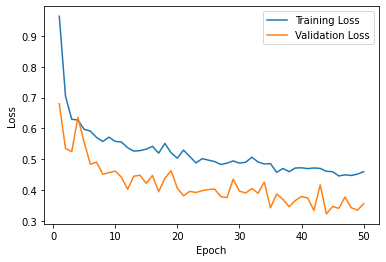

In [31]:
epochs = range(1, len(train_accuracy) + 1)

#plotting the loss 
plt.plot(epochs, train_loss_list, label = 'Training Loss')
plt.plot(epochs, val_loss_list, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 1.0, 'Testing Accuracy of the CNN')

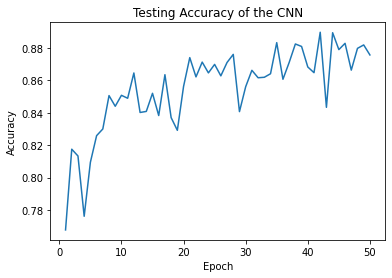

In [32]:
plt.plot(epochs, test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy of the CNN')

In [40]:
# What was the max accuracy?
print('The Maximum accuracy obtained was: ', max(test_accuracy), 'in Epoch: ', epoch_num[test_accuracy.index(max(test_accuracy))])

The Maximum accuracy obtained was:  0.8896539548022598 in Epoch:  41


## Results

The model performs extremely well on the validation data with a loss of approximately 0.39 over only 50 epochs. It also hovers around 86 to 89% accuracy over the entire training time. This is a pretty amazing result and I am pretty proud of all of the different ideas that I took from other places/other people's work. The data is available in the csv saved above, and the model parameters as well as the model itself is saved below. 


In [33]:
# Saving the model for later use (This ends the nightmare of having to train again)
saved_parameters = torch.save(model.state_dict(), 'cassava-disease/modelstate-final.pth')
saved_model = torch.save(model, 'cassava-disease/model-final.pth')
